<a href="https://colab.research.google.com/github/DanielAlvaradejo/challengeLatam-data-science-robot-trading/blob/main/Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lógica básica

La primer parte de este robot se basa en una lógica simple pero efectiva, la cual verifica los siguientes parámetros para que el robot haga una toma de decisión

Si el precio actual es mayor/igual que el precio promedio y la tendencia es de baja, entonces guarda el valor ‘Vender’.

Si el precio actual es menor que el precio promedio y la tendencia es de alta, entonces guarda el valor ‘Comprar’.

Si ninguna de las 2 condiciones anteriores se cumple, entonces guarda el valor 'Esperar'.

##Preparando el ambiente

In [130]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [131]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

##Extrayendo Datos

###Precios historicos del Bitcoin

In [132]:
def importar_base_bitcoin():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  # Obtener datos históricos del Bitcoin en dólares (BTC-USD)
  bitcoin_data = yf.download(tickers='BTC-USD', period='7d', interval='5m')

  # Guardar los datos en un dataframe
  df_bitcoin = pd.DataFrame(bitcoin_data)

In [133]:
importar_base_bitcoin()
df_bitcoin.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-03-10 00:00:00+00:00,68467.742188,68492.843750,68467.742188,68470.218750,68470.218750,0
2024-03-10 00:05:00+00:00,68468.617188,68468.617188,68437.242188,68461.828125,68461.828125,0
2024-03-10 00:10:00+00:00,68461.273438,68465.054688,68426.156250,68426.156250,68426.156250,0
2024-03-10 00:15:00+00:00,68417.171875,68436.632812,68413.242188,68436.632812,68436.632812,0
2024-03-10 00:20:00+00:00,68455.585938,68511.359375,68455.585938,68501.406250,68501.406250,0


### Indicadores de Tendencias

In [134]:
import requests
from bs4 import BeautifulSoup

def extraer_tendencias():
    global precio_actual, tendencia

    # Definir la URL de la página de CoinMarketCap
    url = "https://coinmarketcap.com/currencies/bitcoin/"

    # Realizar la solicitud GET a la página
    response = requests.get(url)

    # Verificar si la solicitud fue exitosa
    if response.status_code == 200:
        # Parsear el contenido HTML de la página
        soup = BeautifulSoup(response.text, 'html.parser')

        # Buscar el elemento que contiene el precio actual del Bitcoin
        bitcoin_price_element = soup.find('div', class_='sc-f70bb44c-0 flfGQp flexStart alignBaseline')

        # Extraer el precio actual del Bitcoin en dólares
        precio_texto = bitcoin_price_element.find('span', class_='sc-f70bb44c-0 jxpCgO base-text').text
        precio_actual = float(precio_texto.replace('$', '').replace(',', ''))

        # Buscar el elemento que contiene la variación del precio en la última hora
        variation_element = bitcoin_price_element.find('span', class_='sc-f70bb44c-0 jxpCgO base-text').find_next_sibling()

        # Extraer la variación del precio en la última hora
        variacion_texto = variation_element.text.strip('%\xa0(1d)').replace(',', '')
        variacion = float(variacion_texto)

        # Determinar la tendencia
        if variacion < 0:
            tendencia = 'baja'
        else:
            tendencia = 'alta'
    else:
        print("Error al cargar la página de CoinMarketCap")

    # # Imprimir el precio actual y la tendencia
    # print("Precio actual del Bitcoin (USD):", precio_actual)
    # print("Tendencia:", tendencia)


In [135]:
extraer_tendencias()

## Limpieza de datos


In [136]:
print(df_bitcoin.info())
df_bitcoin.describe().round(0)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1990 entries, 2024-03-10 00:00:00+00:00 to 2024-03-16 21:55:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1990 non-null   float64
 1   High       1990 non-null   float64
 2   Low        1990 non-null   float64
 3   Close      1990 non-null   float64
 4   Adj Close  1990 non-null   float64
 5   Volume     1990 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 108.8 KB
None


,Open,High,Low,Close,Adj Close,Volume
count,1990.0,1990.0,1990.0,1990.0,1990.0,1.990000e+03
mean,70582.0,70634.0,70528.0,70582.0,70582.0,7.088023e+07
std,1923.0,1920.0,1927.0,1924.0,1924.0,1.583157e+08
min,66095.0,66178.0,66095.0,66178.0,66178.0,0.000000e+00
25%,68933.0,68981.0,68876.0,68917.0,68917.0,0.000000e+00
50%,70934.0,71017.0,70837.0,70925.0,70925.0,1.234125e+07
75%,72219.0,72271.0,72164.0,72220.0,72220.0,8.399872e+07
max,73651.0,73750.0,73593.0,73718.0,73718.0,2.431238e+09


<Axes: >

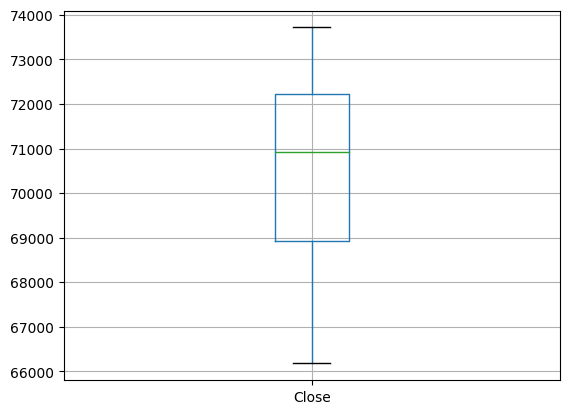

In [137]:
df_bitcoin.boxplot(['Close'])

In [138]:
def limpieza_datos():
    global df_bitcoin_limpio, df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

    # Realizar una copia del DataFrame df_bitcoin
    df_bitcoin_limpio = df_bitcoin.copy()

    # Eliminar la columna 'Adj Close' y restablecer el índice
    df_bitcoin_limpio = df_bitcoin_limpio.drop('Adj Close', axis=1).reset_index()

    # Verificar duplicados en la columna 'Datetime'
    duplicados_en_datetime = df_bitcoin_limpio['Datetime'].duplicated(keep='first')
    # if not duplicados_en_datetime.any():
    #     print("No se encontraron duplicados en la columna 'Datetime'.")
    # else:
    #     print("Se encontraron duplicados en la columna 'Datetime'.")
    #     print(duplicados_en_datetime)

    # Buscar valores nulos en la columna "Close"
    valores_nulos = df_bitcoin_limpio["Close"].isnull().sum()
    if valores_nulos > 0:
        # print(f"Se encontraron {valores_nulos} valores nulos en la columna 'Close'.")
        # Tratar los valores nulos (por ejemplo, reemplazarlos con un valor promedio)
        df_bitcoin_limpio["Close"].fillna(df_bitcoin_limpio["Close"].mean(), inplace=True)
        # print("Los valores nulos han sido tratados.")
    # else:
    #     print("No se encontraron valores nulos en la columna 'Close'.")

    # Filtrar los registros con volumen de transacción mayor a 0
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio["Volume"] > 0]

    # Verificar si se eliminaron registros
    registros_eliminados = len(df_bitcoin) - len(df_bitcoin_limpio)
    # if registros_eliminados > 0:
    #     print(f"Se eliminaron {registros_eliminados} registros con volumen de transacción menor o igual a 0.")
    # else:
    #     print("No se encontraron registros con volumen de transacción menor o igual a 0.")

    # Calcular los cuartiles Q1 y Q3
    Q1 = df_bitcoin_limpio["Close"].quantile(0.25)
    Q3 = df_bitcoin_limpio["Close"].quantile(0.75)

    # Filtrar los registros con valores entre Q1 y Q3
    df_bitcoin_limpio = df_bitcoin_limpio[
        (df_bitcoin_limpio["Close"] >= Q1) & (df_bitcoin_limpio["Close"] <= Q3)
    ]

    # Verificar si se eliminaron registros
    registros_eliminados = len(df_bitcoin) - len(df_bitcoin_limpio)
    # if registros_eliminados > 0:
    #     print(f"Se eliminaron {registros_eliminados} registros con valores atípicos.")
    # else:
    #     print("No se encontraron valores atípicos en la columna 'Close'.")

    # Calcular el precio promedio del Bitcoin (Close)
    media_bitcoin = df_bitcoin_limpio["Close"].mean()
    # print(f"Precio promedio del Bitcoin (Close): ${media_bitcoin:.2f}")

    # # Generar un diagrama de caja para visualizar los datos de la columna 'Close'
    # df_bitcoin_limpio.boxplot(["Close"])


In [139]:
limpieza_datos()


##Toma de decisiones

###Toma de decisiones básica

In [156]:
from ast import And
def tomar_decisiones():
      global df_bitcoin_limpio, df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

      if precio_actual >= media_bitcoin and tendencia == 'baja':
        algoritmo_decision = 'Vender'
      elif precio_actual < media_bitcoin and tendencia == 'alta':
        algoritmo_decision = 'Comprar'
      else:
        algoritmo_decision = 'Esperar'
      print('Utilizando el algoritmo básico')
      print(f'La recomendación es: {algoritmo_decision}')

In [141]:
tomar_decisiones()

Utilizando el algoritmo básico
La recomendación es: Comprar


##Visualización

In [153]:
def visualizacion_basica():
      global df_bitcoin_limpio, df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision
      df_bitcoin[['Promedio']] = media_bitcoin

          # Configurar el tamaño del gráfico en una proporción de 16x5
      plt.figure(figsize=(16, 5))

      # Adicionar un título al gráfico
      plt.title('Precio de Bitcoin vs. Precio Promedio (báscio)')

      # Dibujar una línea con los datos del índice y la columna Close
      df_bitcoin['Close'].plot(label='Precio de Bitcoin')

      # Dibujar una línea con los datos del índice y la columna Promedio
      df_bitcoin['Promedio'].plot(label='Precio Promedio')

      # Mostrar un mensaje con la decisión del algoritmo
      plt.annotate(algoritmo_decision, xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]),
                  xytext=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1] + 500),
                  arrowprops=dict(facecolor='black', arrowstyle='->'),
                  fontsize=12)

      # Mostrar el gráfico
      plt.legend()
      plt.show()


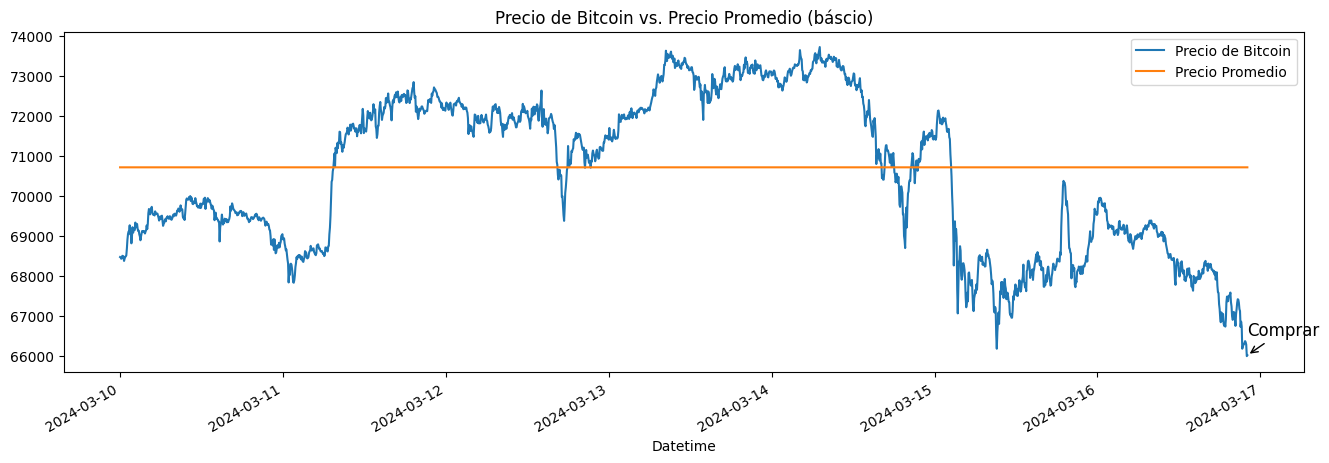

In [154]:
visualizacion_basica()

##Automatización

#MYC trading indicator

1.  **Tendencia:** Esta es una medida de la dirección general del precio de una criptomoneda. Puede ser alcista (subiendo) o bajista (bajando).

2.  **Osciladores de impulso:** Estos son indicadores técnicos que utilizan la velocidad y el cambio de los movimientos de precios para generar señales de trading.

3.  **Línea de tendencia:** Una característica clave del indicador es la línea de tendencia, que cuando el precio cruza hacia arriba, indica que se puede imprimir una señal larga, y a la inversa, cuando el precio cruza hacia abajo indica que se puede imprimir una señal corta.

4.  **Punto de entrada recomendado y punto de salida:** A diferencia de otros indicadores públicos como el RSI y las Bandas de Bollinger, este indicador proporciona un punto de entrada recomendado así como un punto de salida para que los traders puedan concentrarse más en determinar el tamaño de su posición o el apalancamiento.

##Oscilador Estocástico

Este oscilador compara el precio de cierre de un activo con su rango de precios durante un período de tiempo específico. La fórmula para calcular el Oscilador Estocástico es la siguiente:



$\%K = \left( \frac{C - L_{14}}{H_{14} - L_{14}} \right) \times 100$

Donde:

$C$ es el precio de cierre más reciente.

$L_{14}$ es el precio más bajo registrado durante los últimos 14 períodos.

$H_{14}$ es el precio más alto registrado durante los últimos 14 períodos.



---


La fórmula para calcular el %D, la media móvil de n períodos del %K, es:



$\%D = \text{Media Móvil de } \%K \text{ en } n \text{ períodos}$


In [144]:
precios_ultimos_14_periodos = []


def precios_oscilador_estocastico():
    global precio_actual, tendencia, precio_mas_bajo, precio_mas_alto

      # Agrega el precio actual a la lista de precios de los últimos 14 periodos
    precios_ultimos_14_periodos.append(precio_actual)

    # Si la longitud de la lista de precios supera los 14 periodos, remueve el primer elemento
    if len(precios_ultimos_14_periodos) > 14:
        precios_ultimos_14_periodos.pop(0)

    # Si se tienen al menos 14 periodos almacenados, calcula el precio más bajo y el precio más alto
    if len(precios_ultimos_14_periodos) >= 14:
        precio_mas_bajo = min(precios_ultimos_14_periodos)
        precio_mas_alto = max(precios_ultimos_14_periodos)

    # # Imprime el precio mas bajo y mas alto
    # print("Precio más bajo de los últimos 14 periodos:", precio_mas_bajo)
    # print("Precio más alto de los últimos 14 periodos:", precio_mas_alto)

In [149]:
def tomar_decision_MYC():
      global df_bitcoin_limpio, df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, precio_mas_bajo, precio_mas_alto, valor_estocastico, estado, decision

      valor_estocastico = ((precio_actual-precio_mas_bajo)/(precio_mas_alto-precio_mas_bajo))*100

      # Determina el estado del mercado

      if valor_estocastico < 30:
        estado = 'Sobrevendido'
      elif valor_estocastico > 70:
        estado = 'Sobrecomprado'
      else:
        estado = 'Neutro'

      # Utilizando la tendencia y el oscilador, se crean las alertas

      if tendencia == 'alta' and estado == 'Sobrevendido':
        decision = 'Comprar'
      elif tendencia =='baja' and estado == 'Sobrecomprado':
        decision = 'Vender'
      else:
        decision = 'Esperar'
      # Imprimir recomendacion
      print('Utilizando el indicador MYC')
      print(f'La recomendación es: {decision}')


In [152]:
def visualizacion_MYC():
      global df_bitcoin_limpio, df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, precio_mas_bajo, precio_mas_alto, valor_estocastico, estado, decision
      df_bitcoin[['Promedio']] = media_bitcoin

          # Configurar el tamaño del gráfico en una proporción de 16x5
      plt.figure(figsize=(16, 5))

      # Adicionar un título al gráfico
      plt.title('Precio de Bitcoin vs. Precio Promedio (Indice MYC)')

      # Dibujar una línea con los datos del índice y la columna Close
      df_bitcoin['Close'].plot(label='Precio de Bitcoin')

      # Dibujar una línea con los datos del índice y la columna Promedio
      df_bitcoin['Promedio'].plot(label='Precio Promedio')

      # Mostrar un mensaje con la decisión del algoritmo
      plt.annotate(decision, xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]),
                  xytext=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1] + 500),
                  arrowprops=dict(facecolor='black', arrowstyle='->'),
                  fontsize=12)

      # Mostrar el gráfico
      plt.legend()
      plt.show()


[*********************100%%**********************]  1 of 1 completed


Utilizando el algoritmo básico
La recomendación es: Comprar


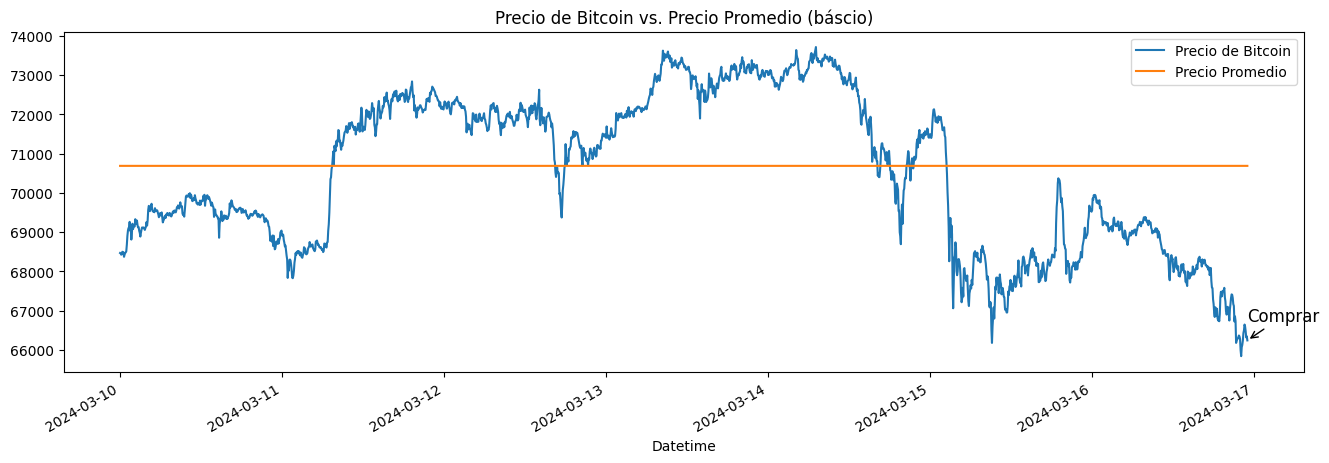

Utilizando el indicador MYC
La recomendación es: Comprar


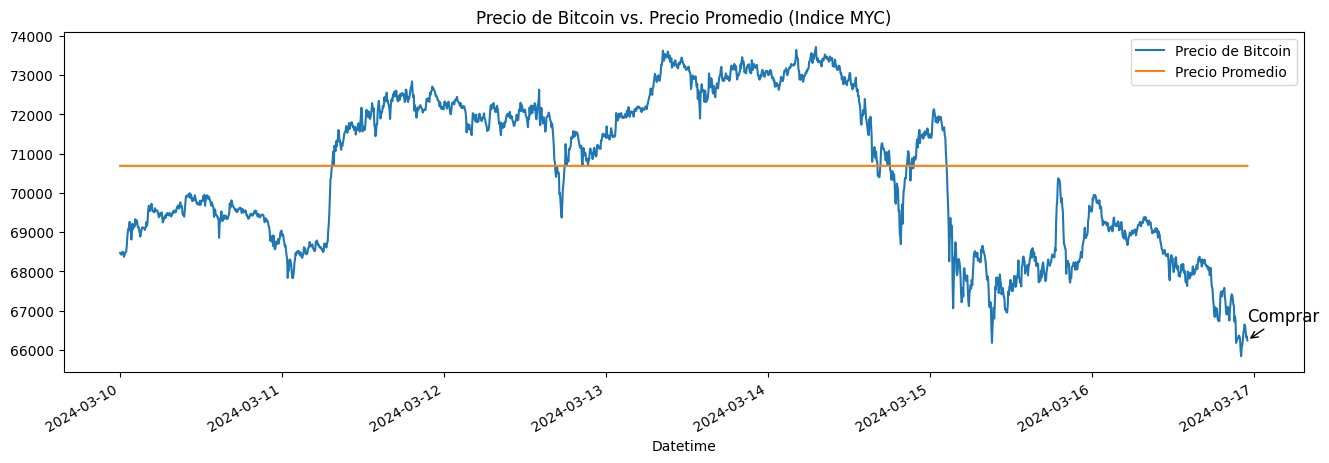

Número de periodos transcurridos: 17


In [ ]:
from IPython.display import clear_output

import time
contador= 0
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion_basica()
  precios_oscilador_estocastico()
  if len(precios_ultimos_14_periodos) == 14:
    tomar_decision_MYC()
    visualizacion_MYC()

  contador += 1

   # Imprime el número de periodos que han pasado
  print("Número de periodos transcurridos:", contador)
  time.sleep(30)